<a href="https://colab.research.google.com/github/Mahesh7667/Knowing-Your-Customers-A-Data-Driven-Approach/blob/main/Code/Knowing_Your_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow pandas numpy matplotlib scikit-learn lifetimes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.8 MB/s eta 0:00:00


# Churn Analysis and Customer Segmentation Script

---

This notebook performs the following tasks:
  - Loads and preprocesses the dataset.
  - Computes RFM (Recency, Frequency, Monetary) metrics.
  - Scores and segments customers using two segmentation strategies.
  - Performs K-Means clustering (with an elbow method plot for guidance).
  - Trains classification models (RandomForest and Neural Network) to predict clusters.
  - Estimates Customer Lifetime Value (CLV) using the lifetimes package.
  - Maps the customer journey over time with interactive visualizations.
  - (Optional) Loads data from Google BigQuery.

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Machine Learning and preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

# TensorFlow for Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# CLV estimation libraries
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Interactive visualizations
import plotly.express as px
from collections import Counter

# Statistical transformations
from scipy.stats import boxcox, yeojohnson
from scipy.stats.mstats import winsorize


# 1. DATA LOADING AND PREPROCESSING


In [3]:
def load_data(filepath="online_retail_II.xlsx"):
    """
    Loads the dataset from an Excel file.

    Parameters:
      filepath (str): Path to the Excel file.

    Returns:
      df (DataFrame): Loaded DataFrame.
    """
    try:
        df = pd.read_excel(filepath, engine='openpyxl')
        print("Data loaded successfully.")
        return df
    except Exception as e:
        print("Error loading data:", e)
        raise

def preprocess_data(df):
    """
    Preprocesses the raw dataset:
      - Drops rows with missing Customer ID.
      - Filters rows with positive Quantity and Price.
      - Computes TotalSales.
      - Converts InvoiceDate to datetime.

    Parameters:
      df (DataFrame): Raw dataset.

    Returns:
      df (DataFrame): Preprocessed DataFrame.
    """
    df.dropna(subset=['Customer ID'], inplace=True)
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
    df['TotalSales'] = df['Quantity'] * df['Price']
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    return df

# 2. RFM CALCULATION, SCORING & SEGMENTATION


In [4]:
def compute_rfm(df, reference_date=None):
    """
    Computes RFM metrics (Recency, Frequency, Monetary) for each customer.

    Parameters:
      df (DataFrame): Preprocessed dataset.
      reference_date (datetime): Reference date for recency calculation.
         If None, one day after the maximum InvoiceDate is used.

    Returns:
      rfm (DataFrame): DataFrame with RFM metrics indexed by Customer ID.
    """
    if reference_date is None:
        reference_date = df['InvoiceDate'].max() + timedelta(days=1)

    rfm = df.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'Invoice': 'nunique',
        'TotalSales': 'sum'
    })
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    return rfm

def score_rfm(rfm):
    """
    Calculates RFM scores using both equal-frequency binning and custom quantile scoring.

    Parameters:
      rfm (DataFrame): DataFrame with RFM metrics.

    Returns:
      rfm (DataFrame): DataFrame with added score columns.
    """
    # Use qcut for equal-frequency binning. Higher score is better.
    rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
    rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
    rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

    # Custom scoring using quantiles
    quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
    def rfm_score(x, quantiles):
        if x <= quantiles[0.25]:
            return 1
        elif x <= quantiles[0.50]:
            return 2
        elif x <= quantiles[0.75]:
            return 3
        else:
            return 4
    rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=(quantiles['Recency'],))
    rfm['F_Score'] = rfm['Frequency'].apply(rfm_score, args=(quantiles['Frequency'],))
    rfm['M_Score'] = rfm['Monetary'].apply(rfm_score, args=(quantiles['Monetary'],))

    # Combined score as a string (optional)
    rfm['RFM_Score_Str'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

    # Combined numeric score from qcut scores
    rfm['RFM_Score'] = rfm['RecencyScore'] + rfm['FrequencyScore'] + rfm['MonetaryScore']
    return rfm

def segment_customers(rfm, method="rfm_numeric"):
    """
    Segments customers based on RFM scores.

    Parameters:
      rfm (DataFrame): DataFrame with RFM scores.
      method (str): Which segmentation method to use.
          "rfm_numeric" uses the combined numeric score,
          "custom" uses rules based on individual R, F, and M scores.

    Returns:
      rfm (DataFrame): DataFrame with a new column 'Segment'.
    """
    if method == "rfm_numeric":
        def segment(row):
            if row['RFM_Score'] >= 9:
                return 'Champions'
            elif row['RFM_Score'] >= 6:
                return 'Potential Loyalists'
            elif row['RFM_Score'] >= 5:
                return 'At Risk Customers'
            else:
                return 'Lost'
    elif method == "custom":
        def segment(row):
            if row['RFM_Score_Str'] == '444':
                return 'Best Customers'
            elif row['R_Score'] == 4:
                return 'Loyal Customers'
            elif row['F_Score'] == 4:
                return 'Frequent Buyers'
            elif row['M_Score'] == 4:
                return 'Big Spenders'
            else:
                return 'Others'
    else:
        raise ValueError("Invalid segmentation method provided.")

    rfm['Segment'] = rfm.apply(segment, axis=1)
    return rfm

def plot_segment_counts(rfm, title="Customer Segments"):
    """
    Plots the counts of customer segments.

    Parameters:
      rfm (DataFrame): DataFrame with a 'Segment' column.
      title (str): Title of the plot.
    """
    segment_counts = rfm['Segment'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
    plt.title(title)
    plt.xlabel('Segment')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.show()

# 3. CLUSTERING


In [5]:
def perform_clustering(rfm, n_clusters=4):
    """
    Performs K-Means clustering on the log-transformed and standardized RFM data.

    Parameters:
      rfm (DataFrame): DataFrame with RFM metrics.
      n_clusters (int): Number of clusters for K-Means.

    Returns:
      rfm (DataFrame): DataFrame with a new 'Cluster' column.
      cluster_summary (DataFrame): Summary of clusters.
    """
    # Log transformation and standardization
    rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_log)

    # Elbow method for determining optimal clusters
    sse = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled)
        sse[k] = kmeans.inertia_
    plt.figure(figsize=(10, 6))
    plt.plot(list(sse.keys()), list(sse.values()), marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Determining Optimal Clusters")
    plt.show()

    # Apply K-Means with chosen number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

    # Summarize clusters
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Cluster': 'count'
    }).rename(columns={'Cluster': 'Count'}).reset_index()

    # Visualize cluster summary
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Cluster', y='Count', data=cluster_summary)
    plt.title('Number of Customers in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()

    for metric in ['Recency', 'Frequency', 'Monetary']:
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Cluster', y=metric, data=cluster_summary)
        plt.title(f'Average {metric} in Each Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(f'Average {metric}')
        plt.show()

    return rfm, cluster_summary


# 4. CLASSIFICATION (RandomForest & Neural Network)

In [6]:

def train_classification_models(rfm):
    """
    Trains a RandomForest classifier and a Neural Network on RFM data for cluster prediction.

    Parameters:
      rfm (DataFrame): DataFrame with RFM metrics and Cluster labels.

    Returns:
      rf_model: Trained RandomForestClassifier.
      nn_model: Trained Neural Network model.
      scaler: The StandardScaler instance used for feature scaling.
    """
    X = rfm[['Recency', 'Frequency', 'Monetary']]
    y = rfm['Cluster']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # RandomForest Classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    y_pred_rf = rf_model.predict(X_test_scaled)
    print("RandomForest Classification Report:")
    print(classification_report(y_test, y_pred_rf))
    print("RandomForest Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_rf))

    # Neural Network Classifier
    nn_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(rfm['Cluster'].unique()), activation='softmax')
    ])
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    nn_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test),
                 epochs=20, batch_size=32, callbacks=[early_stop], verbose=0)
    loss, accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Neural Network Test Accuracy: {accuracy:.2f}")

    return rf_model, nn_model, scaler


In [7]:

# =============================================================================
# 5. CUSTOMER LIFETIME VALUE (CLV) ESTIMATION
# =============================================================================
def estimate_clv(df):
    """
    Estimates Customer Lifetime Value (CLV) using BG/NBD and Gamma-Gamma models,
    applies outlier treatments and visualizes the CLV distribution.

    Parameters:
      df (DataFrame): Preprocessed dataset.

    Returns:
      rfm_data (DataFrame): DataFrame with CLV estimates and additional metrics.
    """
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    reference_date = df['InvoiceDate'].max() + timedelta(days=1)

    rfm_data = df.groupby('Customer ID').agg({
        'InvoiceDate': [lambda x: (reference_date - x.max()).days,   # Recency
                        lambda x: (reference_date - x.min()).days],  # T (Customer Age)
        'Invoice': 'count',  # Frequency
        'Price': 'sum'       # Monetary
    }).reset_index()
    rfm_data.columns = ['Customer ID', 'Recency', 'T', 'Frequency', 'Monetary']

    # Remove cases where recency is greater than T and remove first-time buyers
    rfm_data = rfm_data[rfm_data["Recency"] <= rfm_data["T"]]
    rfm_data = rfm_data[rfm_data["Frequency"] > 1]

    # Fit BG/NBD model for purchase predictions
    bgf = BetaGeoFitter(penalizer_coef=0.01)
    bgf.fit(rfm_data["Frequency"], rfm_data["Recency"], rfm_data["T"])
    rfm_data["Predicted_Purchases"] = bgf.predict(180, rfm_data["Frequency"],
                                                  rfm_data["Recency"], rfm_data["T"])

    # Fit Gamma-Gamma model for monetary value predictions
    ggf = GammaGammaFitter()
    ggf.fit(rfm_data["Frequency"], rfm_data["Monetary"])
    rfm_data["Predicted_Monetary"] = ggf.conditional_expected_average_profit(rfm_data["Frequency"],
                                                                             rfm_data["Monetary"])

    # Calculate CLV with a discount factor (here 0.95)
    rfm_data["CLV"] = rfm_data["Predicted_Purchases"] * rfm_data["Predicted_Monetary"] * 0.95

    # Visualize the raw CLV distribution
    plt.figure(figsize=(10, 5))
    plt.hist(rfm_data["CLV"], bins=50, color='blue', alpha=0.7)
    plt.title("Customer Lifetime Value (CLV) Distribution")
    plt.xlabel("CLV")
    plt.ylabel("Number of Customers")
    plt.show()

    # Log-transform the CLV for better visualization
    rfm_data['CLV_Log'] = np.log1p(rfm_data['CLV'])
    plt.figure(figsize=(10, 5))
    sns.histplot(rfm_data['CLV_Log'], bins=50, color='blue', kde=True)
    plt.title('CLV Distribution - Log Scale')
    plt.xlabel('Log(CLV)')
    plt.ylabel('Number of Customers')
    plt.show()

    # Box-Cox transformation (requires strictly positive values)
    rfm_data['CLV_BoxCox'], _ = boxcox(rfm_data['CLV'] + 1)
    sns.histplot(rfm_data['CLV_BoxCox'], kde=True, color='green')
    plt.title('CLV Distribution After Box-Cox Transformation')
    plt.show()

    # Outlier removal using IQR
    Q1 = rfm_data['CLV'].quantile(0.25)
    Q3 = rfm_data['CLV'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rfm_data_no_outliers = rfm_data[(rfm_data['CLV'] >= lower_bound) & (rfm_data['CLV'] <= upper_bound)]
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=rfm_data_no_outliers['CLV'])
    plt.title('Box Plot of CLV After Outlier Removal')
    plt.show()

    # Winsorize the top 1% of CLV values
    rfm_data['CLV_Winsorized'] = winsorize(rfm_data['CLV'], limits=[0, 0.01])
    sns.histplot(rfm_data['CLV_Winsorized'], kde=True, color='red')
    plt.title('CLV Distribution After Winsorization')
    plt.show()

    # Scale CLV for additional analysis
    scaler_mm = MinMaxScaler()
    rfm_data['CLV_Scaled'] = scaler_mm.fit_transform(rfm_data[['CLV']])
    # Create a weighted CLV metric (weights may be tuned)
    rfm_data['Weighted_CLV'] = (rfm_data['CLV_Scaled'] * 0.5) + (rfm_data['Frequency'] * 0.3) + (rfm_data['Recency'] * 0.2)
    sns.histplot(rfm_data['Weighted_CLV'], kde=True, color='blue')
    plt.title('Weighted CLV Distribution')
    plt.show()

    print("Top 10 Customers by CLV:")
    print(rfm_data[['Customer ID', 'CLV']].sort_values(by="CLV", ascending=False).head(10))

    return rfm_data



In [8]:

# =============================================================================
# 6. CUSTOMER JOURNEY MAPPING
# =============================================================================
def customer_journey_mapping(df, rfm_data):
    """
    Maps the customer journey over time using CLV information and creates
    interactive visualizations (Sankey diagram and transition heatmap).

    Parameters:
      df (DataFrame): Original dataset with InvoiceDate.
      rfm_data (DataFrame): CLV estimation DataFrame.

    Returns:
      customer_movements (DataFrame): Pivot table with Customer CLV over months.
    """
    # Merge CLV info into the main dataframe
    df = df.merge(rfm_data[['Customer ID', 'CLV']], on='Customer ID', how='left')
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['Month'] = df['InvoiceDate'].dt.to_period('M')

    # Aggregate average CLV per customer per month
    df_agg = df.groupby(['Customer ID', 'Month'])['CLV'].mean().reset_index()

    # Pivot the data to create a customer movement table
    customer_movements = df_agg.pivot(index="Customer ID", columns="Month", values="CLV").fillna("Unknown")
    print("Customer Movements (Pivot Table):")
    print(customer_movements.head())

    # Count transitions between months using Counter
    transitions = {}
    months = sorted(df_agg["Month"].unique())
    for i in range(len(months) - 1):
        transition_counts = Counter(zip(customer_movements[months[i]], customer_movements[months[i+1]]))
        transitions[months[i]] = transition_counts
    # Prepare transition data for a Sankey (sunburst) diagram
    transition_data = []
    for m, counter in transitions.items():
        for (from_clv, to_clv), count in counter.items():
            transition_data.append((str(m), str(from_clv), str(to_clv), count))
    transition_df = pd.DataFrame(transition_data, columns=["Month", "From_CLV", "To_CLV", "Count"])

    # Create a sunburst chart using Plotly to visualize customer journey flow
    fig = px.sunburst(transition_df, path=['Month', 'From_CLV', 'To_CLV'], values='Count',
                      color='Count', title="Customer Journey Flow Across CLV Segments")
    fig.show()

    # Create a heatmap to show transition patterns
    transition_matrix = pd.crosstab(df_agg["CLV"], df_agg["CLV"].shift(-1))
    plt.figure(figsize=(10, 6))
    sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Customer CLV Transition Heatmap")
    plt.xlabel("Next CLV Segment")
    plt.ylabel("Previous CLV Segment")
    plt.show()

    return customer_movements



In [9]:
# =============================================================================
# 7. (OPTIONAL) BIGQUERY DATA LOADING
# =============================================================================
def load_bigquery_data(project_id="retail-449009", query=None):
    """
    Loads data from Google BigQuery.

    Parameters:
      project_id (str): Google Cloud project ID.
      query (str): SQL query to run.

    Returns:
      df (DataFrame): DataFrame with BigQuery results.
    """
    # Uncomment and adjust the lines below if running in Colab:
    # from google.colab import auth
    # auth.authenticate_user()
    from google.cloud import bigquery
    client = bigquery.Client(project=project_id)
    if query is None:
        query = """
        SELECT *
        FROM `retail-449009.retailsales.customer_clusters`
        """
    df = client.query(query).to_dataframe()
    print("BigQuery data loaded successfully.")
    return df


In [10]:
!curl -o online_retail_II.zip "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
!unzip online_retail_II.zip
!rm online_retail_II.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.5M    0 43.5M    0     0  20.4M      0 --:--:--  0:00:02 --:--:-- 20.4M
Archive:  online_retail_II.zip
 extracting: online_retail_II.xlsx   


# 8. MAIN EXECUTION


In [11]:

# Load and preprocess the data
df = load_data("online_retail_II.xlsx")
df = preprocess_data(df)


Data loaded successfully.


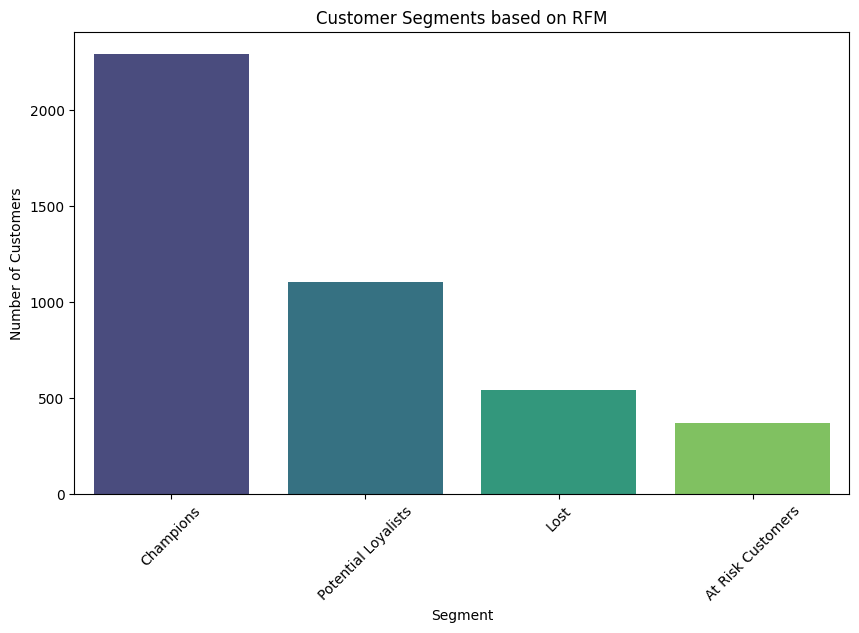

             Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
Customer ID                                                               
12346.0          165         11    372.86             2               5   
12347.0            3          2   1323.32             5               2   
12348.0           74          1    222.16             2               1   
12349.0           43          3   2671.14             3               3   
12351.0           11          1    300.93             5               1   

             MonetaryScore  R_Score  F_Score  M_Score RFM_Score_Str  \
Customer ID                                                           
12346.0                  2        4        4        2           442   
12347.0                  4        1        2        3           123   
12348.0                  1        3        1        1           311   
12349.0                  5        2        3        4           234   
12351.0                  2        1        1    

In [12]:

# Compute RFM metrics and score them
rfm = compute_rfm(df)
rfm = score_rfm(rfm)
rfm = segment_customers(rfm, method="rfm_numeric")
plot_segment_counts(rfm, title="Customer Segments based on RFM")
print(rfm.head())

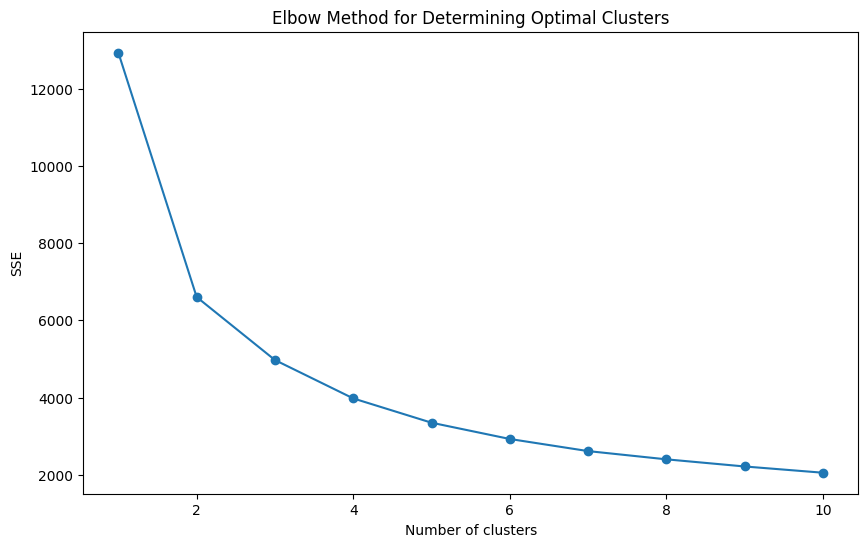

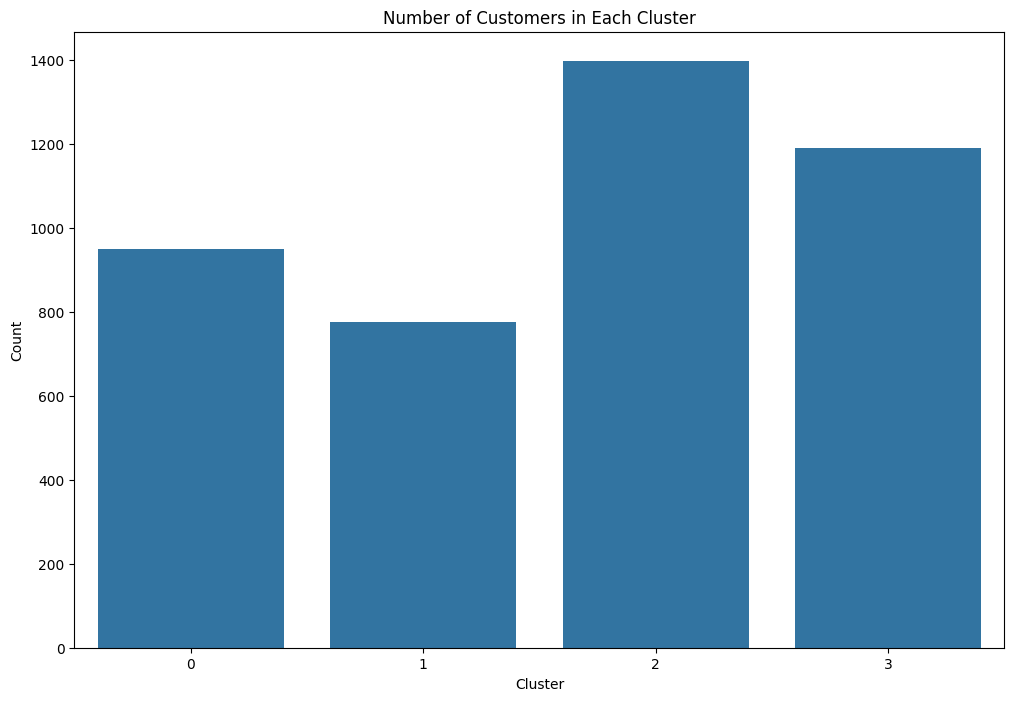

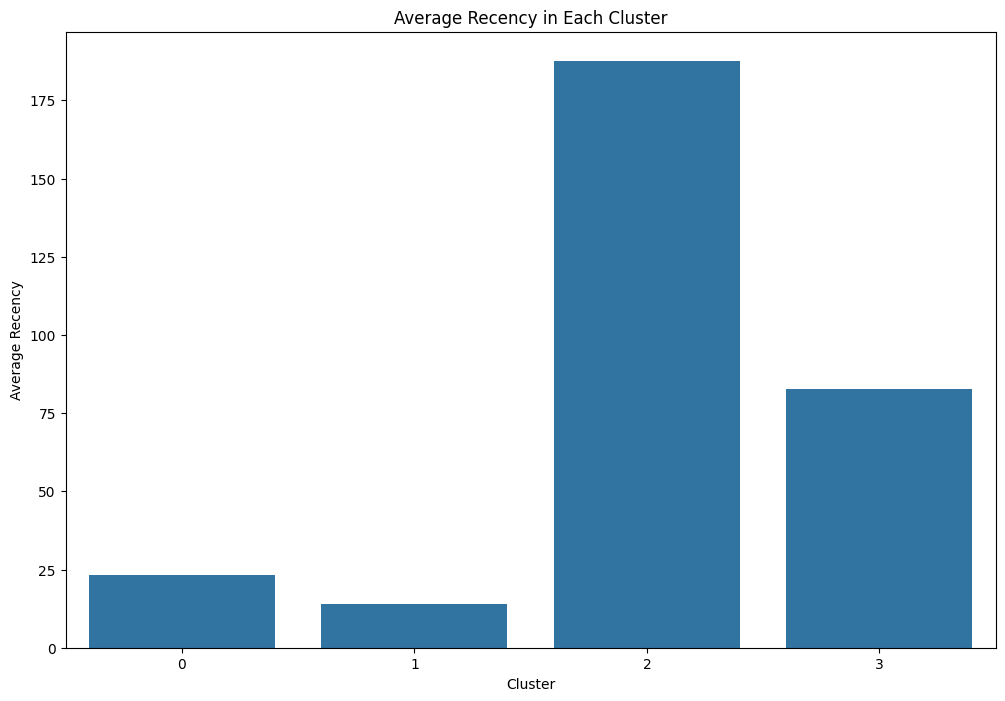

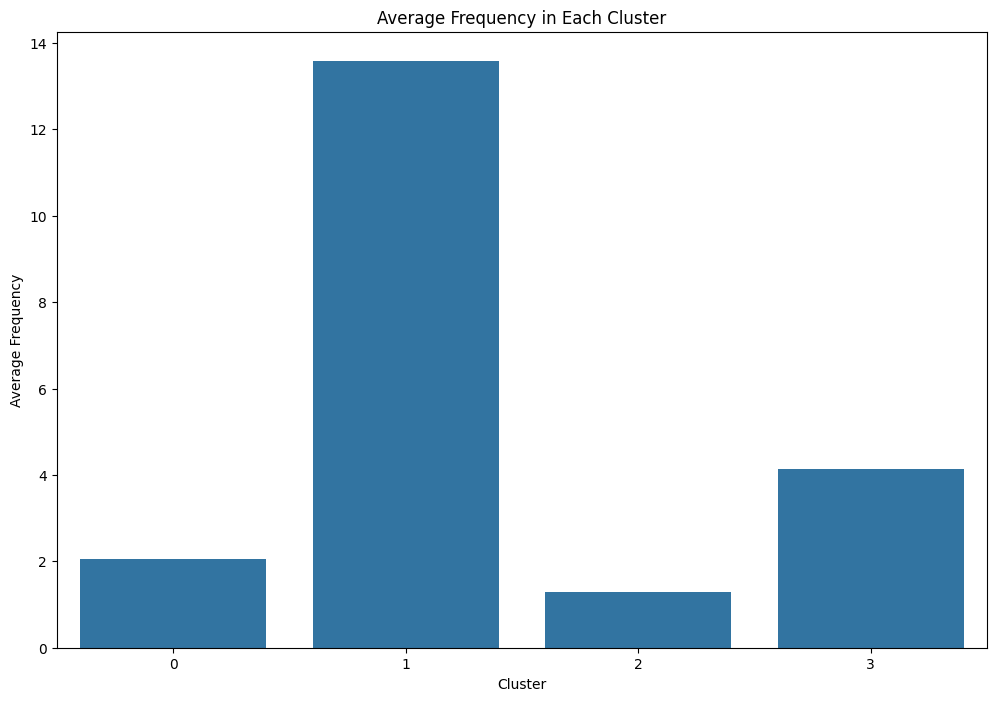

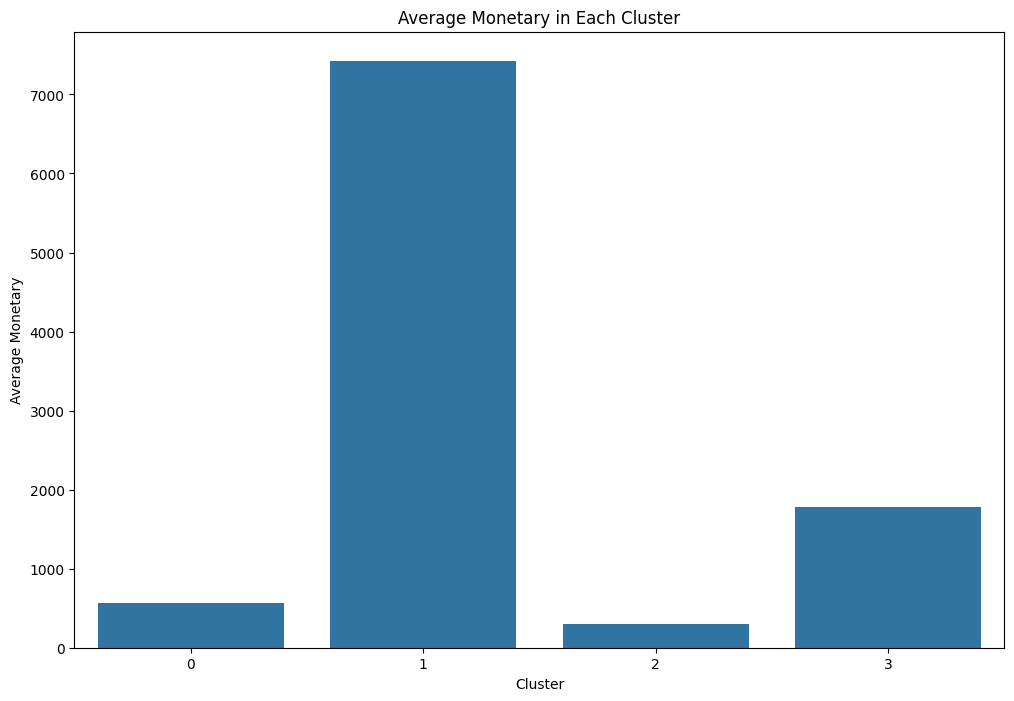

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       190
           1       0.98      0.96      0.97       159
           2       0.99      0.98      0.99       274
           3       0.97      0.98      0.98       240

    accuracy                           0.98       863
   macro avg       0.98      0.98      0.98       863
weighted avg       0.98      0.98      0.98       863

RandomForest Confusion Matrix:
[[188   0   2   0]
 [  2 152   0   5]
 [  2   0 269   3]
 [  0   3   1 236]]
Neural Network Test Accuracy: 0.97


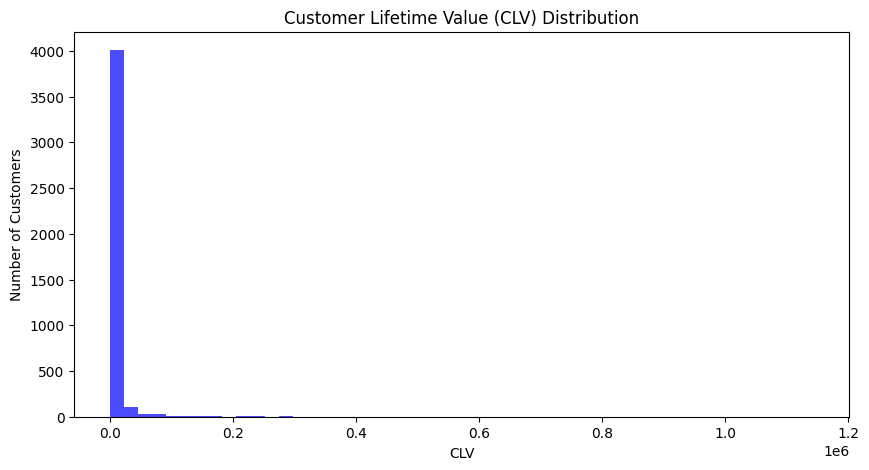

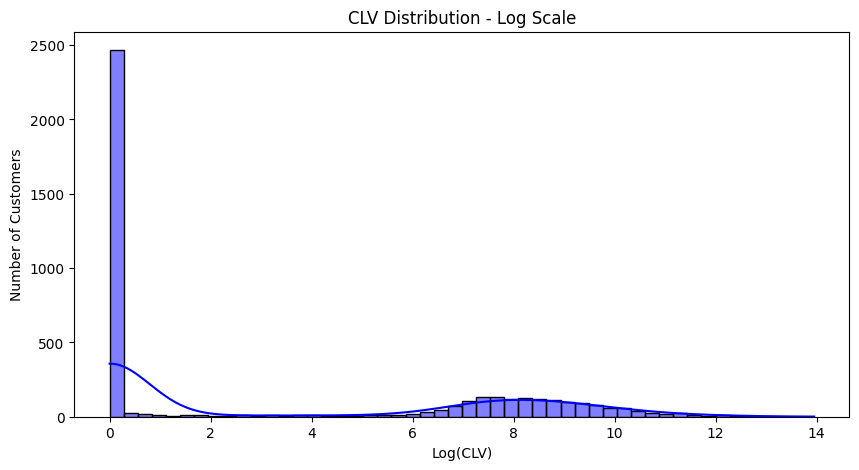

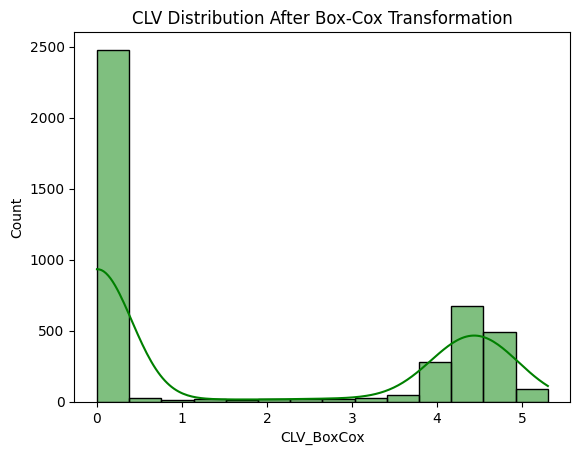

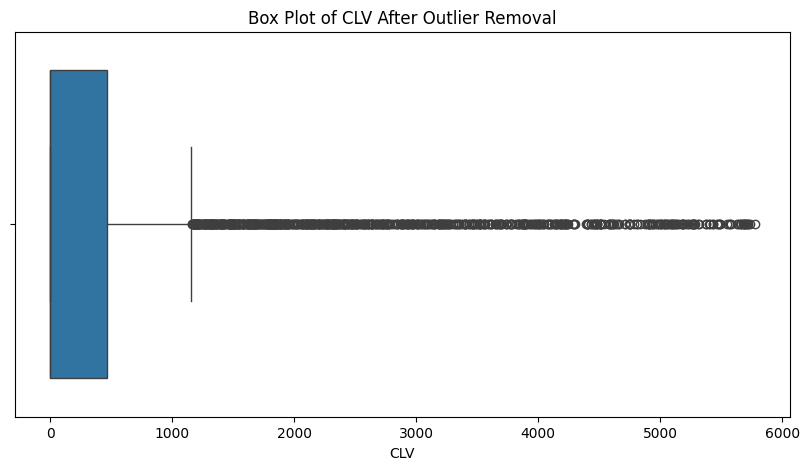

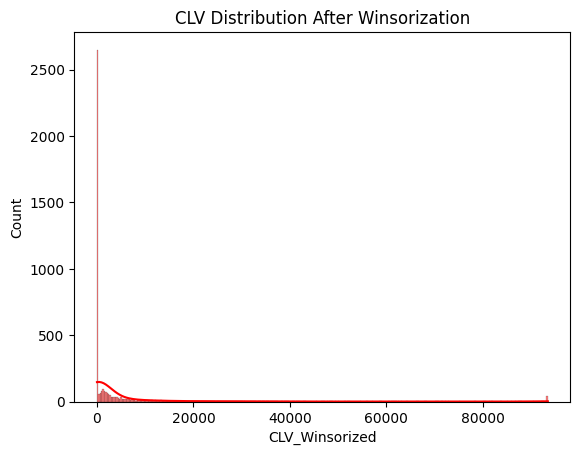

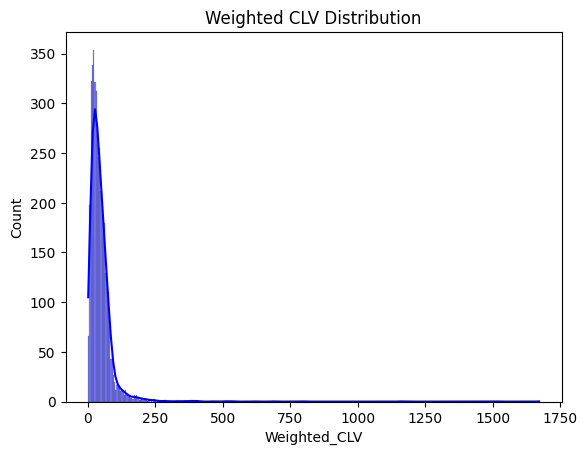

Top 10 Customers by CLV:
      Customer ID           CLV
9         12357.0  1.144595e+06
2998      16501.0  7.141358e+05
4136      18043.0  5.739426e+05
2532      15880.0  4.863661e+05
2056      15211.0  3.297369e+05
459       13030.0  3.009427e+05
1830      14899.0  2.925140e+05
3561      17269.0  2.865171e+05
1434      14382.0  2.826708e+05
114       12511.0  2.701888e+05


In [13]:

# Perform clustering and visualize results
rfm, cluster_summary = perform_clustering(rfm, n_clusters=4)

# Train classification models on the RFM data for predicting clusters
rf_model, nn_model, scaler_model = train_classification_models(rfm)

# Estimate Customer Lifetime Value (CLV)
rfm_clv = estimate_clv(df)


In [14]:

# (Optional) Load BigQuery data if needed
# bq_df = load_bigquery_data()
# print(bq_df.head())


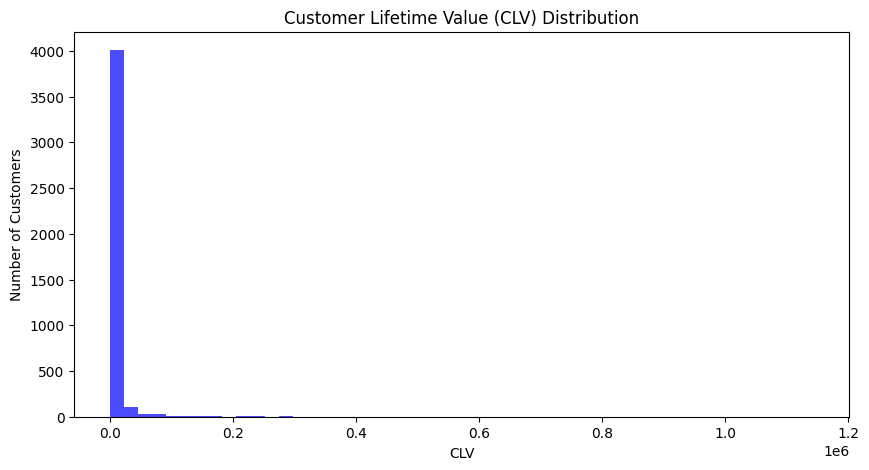

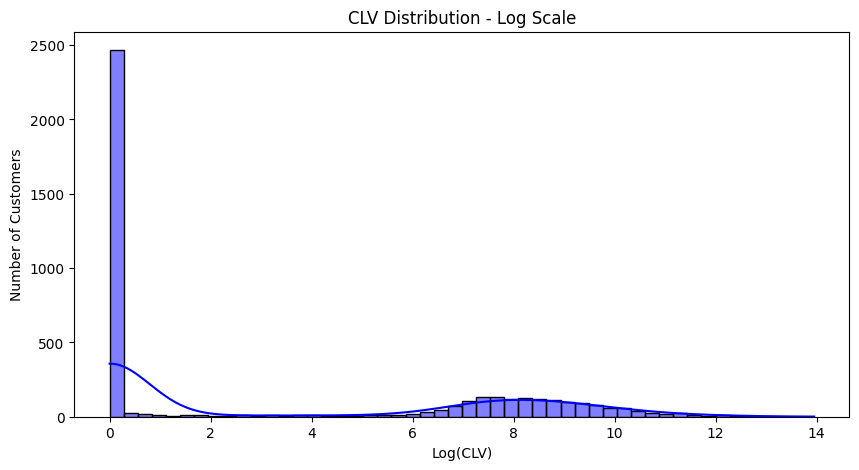

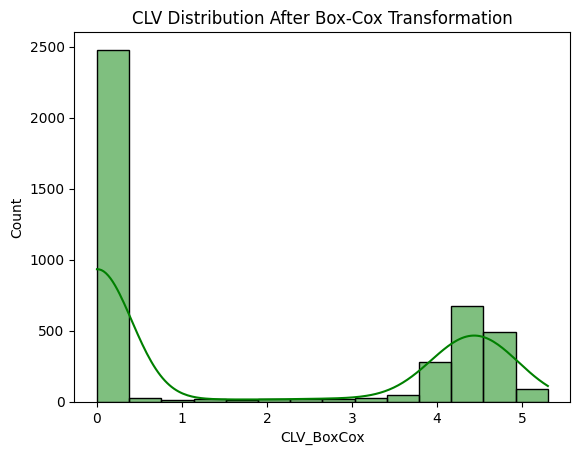

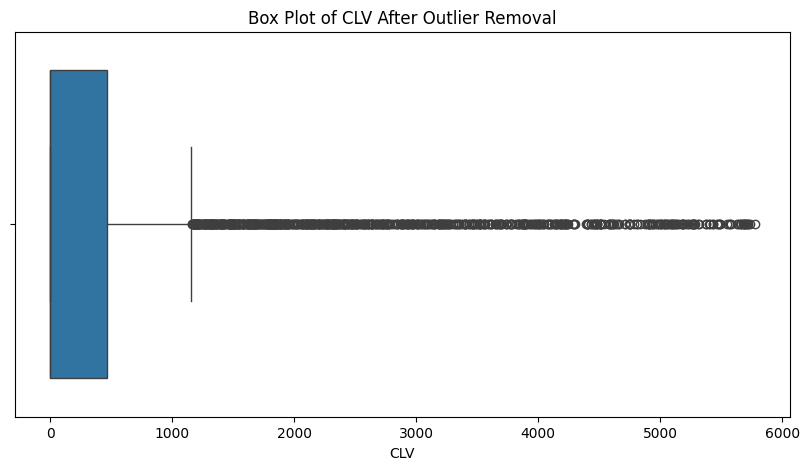

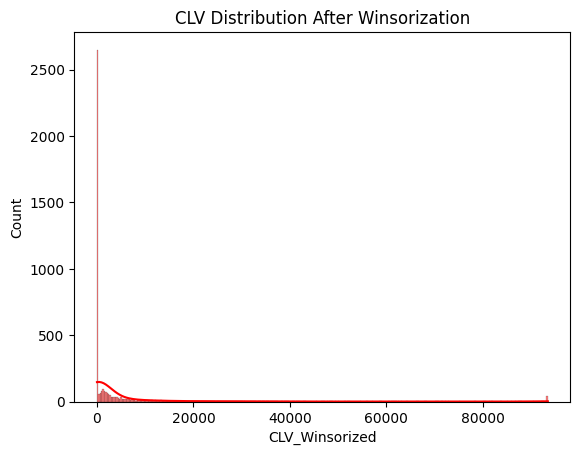

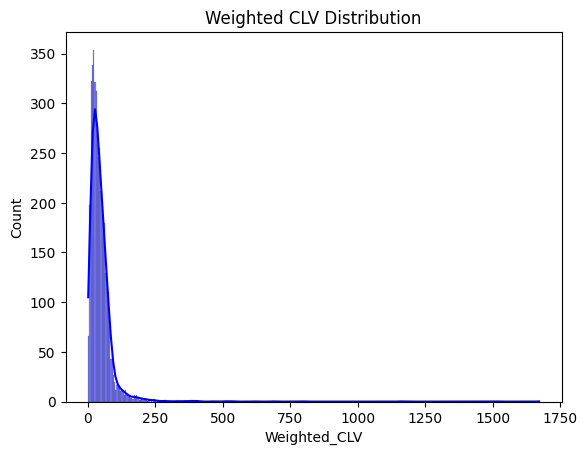

Top 10 Customers by CLV:
      Customer ID           CLV
9         12357.0  1.144595e+06
2998      16501.0  7.141358e+05
4136      18043.0  5.739426e+05
2532      15880.0  4.863661e+05
2056      15211.0  3.297369e+05
459       13030.0  3.009427e+05
1830      14899.0  2.925140e+05
3561      17269.0  2.865171e+05
1434      14382.0  2.826708e+05
114       12511.0  2.701888e+05


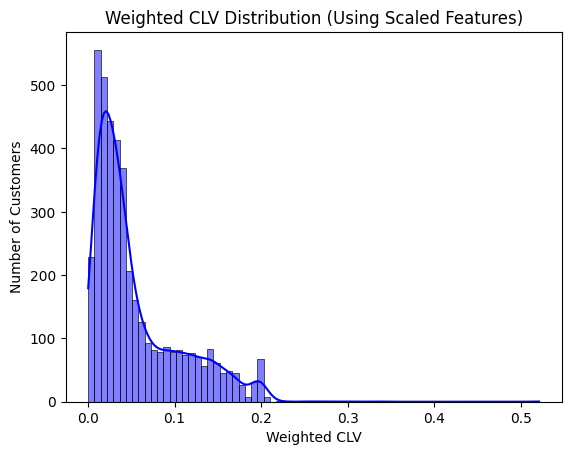

In [15]:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    reference_date = df['InvoiceDate'].max() + timedelta(days=1)

    rfm_data = df.groupby('Customer ID').agg({
        'InvoiceDate': [lambda x: (reference_date - x.max()).days,   # Recency
                        lambda x: (reference_date - x.min()).days],  # T (Customer Age)
        'Invoice': 'count',  # Frequency
        'Price': 'sum'       # Monetary
    }).reset_index()
    rfm_data.columns = ['Customer ID', 'Recency', 'T', 'Frequency', 'Monetary']

    # Remove cases where recency is greater than T and remove first-time buyers
    rfm_data = rfm_data[rfm_data["Recency"] <= rfm_data["T"]]
    rfm_data = rfm_data[rfm_data["Frequency"] > 1]

    # Fit BG/NBD model for purchase predictions
    bgf = BetaGeoFitter(penalizer_coef=0.01)
    bgf.fit(rfm_data["Frequency"], rfm_data["Recency"], rfm_data["T"])
    rfm_data["Predicted_Purchases"] = bgf.predict(180, rfm_data["Frequency"],
                                                  rfm_data["Recency"], rfm_data["T"])

    # Fit Gamma-Gamma model for monetary value predictions
    ggf = GammaGammaFitter()
    ggf.fit(rfm_data["Frequency"], rfm_data["Monetary"])
    rfm_data["Predicted_Monetary"] = ggf.conditional_expected_average_profit(rfm_data["Frequency"],
                                                                             rfm_data["Monetary"])

    # Calculate CLV with a discount factor (here 0.95)
    rfm_data["CLV"] = rfm_data["Predicted_Purchases"] * rfm_data["Predicted_Monetary"] * 0.95

    # Visualize the raw CLV distribution
    plt.figure(figsize=(10, 5))
    plt.hist(rfm_data["CLV"], bins=50, color='blue', alpha=0.7)
    plt.title("Customer Lifetime Value (CLV) Distribution")
    plt.xlabel("CLV")
    plt.ylabel("Number of Customers")
    plt.show()

    # Log-transform the CLV for better visualization
    rfm_data['CLV_Log'] = np.log1p(rfm_data['CLV'])
    plt.figure(figsize=(10, 5))
    sns.histplot(rfm_data['CLV_Log'], bins=50, color='blue', kde=True)
    plt.title('CLV Distribution - Log Scale')
    plt.xlabel('Log(CLV)')
    plt.ylabel('Number of Customers')
    plt.show()

    # Box-Cox transformation (requires strictly positive values)
    rfm_data['CLV_BoxCox'], _ = boxcox(rfm_data['CLV'] + 1)
    sns.histplot(rfm_data['CLV_BoxCox'], kde=True, color='green')
    plt.title('CLV Distribution After Box-Cox Transformation')
    plt.show()

    # Outlier removal using IQR
    Q1 = rfm_data['CLV'].quantile(0.25)
    Q3 = rfm_data['CLV'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rfm_data_no_outliers = rfm_data[(rfm_data['CLV'] >= lower_bound) & (rfm_data['CLV'] <= upper_bound)]
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=rfm_data_no_outliers['CLV'])
    plt.title('Box Plot of CLV After Outlier Removal')
    plt.show()

    # Winsorize the top 1% of CLV values
    rfm_data['CLV_Winsorized'] = winsorize(rfm_data['CLV'], limits=[0, 0.01])
    sns.histplot(rfm_data['CLV_Winsorized'], kde=True, color='red')
    plt.title('CLV Distribution After Winsorization')
    plt.show()

    # Scale CLV for additional analysis
    scaler_mm = MinMaxScaler()
    rfm_data['CLV_Scaled'] = scaler_mm.fit_transform(rfm_data[['CLV']])
    # Create a weighted CLV metric (weights may be tuned)
    rfm_data['Weighted_CLV'] = (rfm_data['CLV_Scaled'] * 0.5) + (rfm_data['Frequency'] * 0.3) + (rfm_data['Recency'] * 0.2)
    sns.histplot(rfm_data['Weighted_CLV'], kde=True, color='blue')
    plt.title('Weighted CLV Distribution')
    plt.show()

    print("Top 10 Customers by CLV:")
    print(rfm_data[['Customer ID', 'CLV']].sort_values(by="CLV", ascending=False).head(10))



    # --- Revised Weighted CLV Calculation ---
    # Instead of scaling only CLV, scale Frequency and Recency as well so that all features are on a comparable [0,1] range.
    features = rfm_data[['CLV', 'Frequency', 'Recency']]
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(features)
    rfm_data['CLV_Scaled'] = scaled_features[:, 0]
    rfm_data['Frequency_Scaled'] = scaled_features[:, 1]
    rfm_data['Recency_Scaled'] = scaled_features[:, 2]

    # Optionally invert Recency since lower recency is better (uncomment if needed)
    # rfm_data['Recency_Scaled'] = 1 - rfm_data['Recency_Scaled']

    # Create a weighted CLV metric using the scaled values
    rfm_data['Weighted_CLV'] = (rfm_data['CLV_Scaled'] * 0.5) + \
                               (rfm_data['Frequency_Scaled'] * 0.3) + \
                               (rfm_data['Recency_Scaled'] * 0.2)
    sns.histplot(rfm_data['Weighted_CLV'], kde=True, color='blue')
    plt.title('Weighted CLV Distribution (Using Scaled Features)')
    plt.xlabel('Weighted CLV')
    plt.ylabel('Number of Customers')
    plt.show()
    # --- End Revised Section ---


In [16]:
print("Top 10 Customers by Weighted CLV:")
print(rfm_data[['Customer ID', 'Weighted_CLV']].sort_values(by="Weighted_CLV", ascending=False).head(10))


Top 10 Customers by Weighted CLV:
      Customer ID  Weighted_CLV
9         12357.0      0.521115
2998      16501.0      0.332657
1840      14911.0      0.300000
3989      17841.0      0.271606
4136      18043.0      0.254703
2532      15880.0      0.220156
1606      14606.0      0.208726
3563      17271.0      0.203500
809       13526.0      0.203252
1889      14979.0      0.203177


In [17]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm_data = df.groupby('Customer ID').agg({
    'InvoiceDate': [lambda x: (reference_date - x.max()).days,   # Recency
                    lambda x: (reference_date - x.min()).days],  # T (Customer Age)
    'Invoice': 'count',  # Frequency
    'Price': 'sum'       # Monetary
}).reset_index()
rfm_data.columns = ['Customer ID', 'Recency', 'T', 'Frequency', 'Monetary']


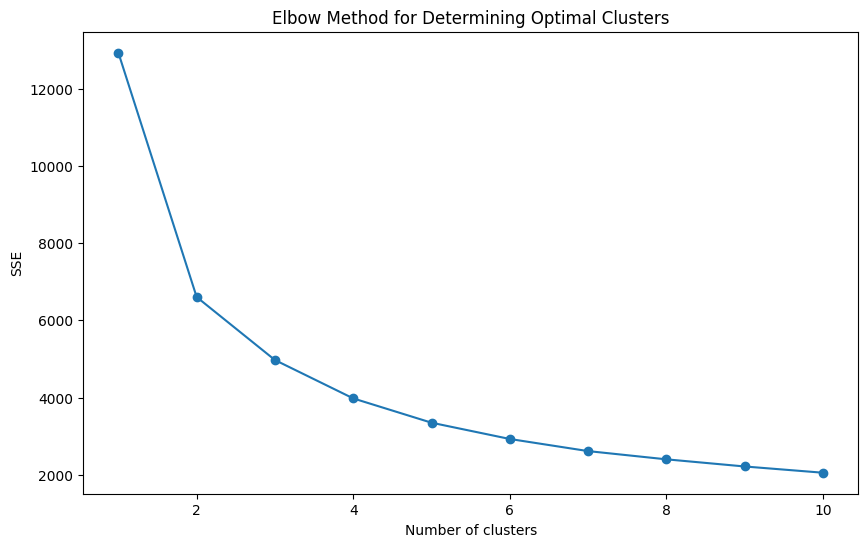

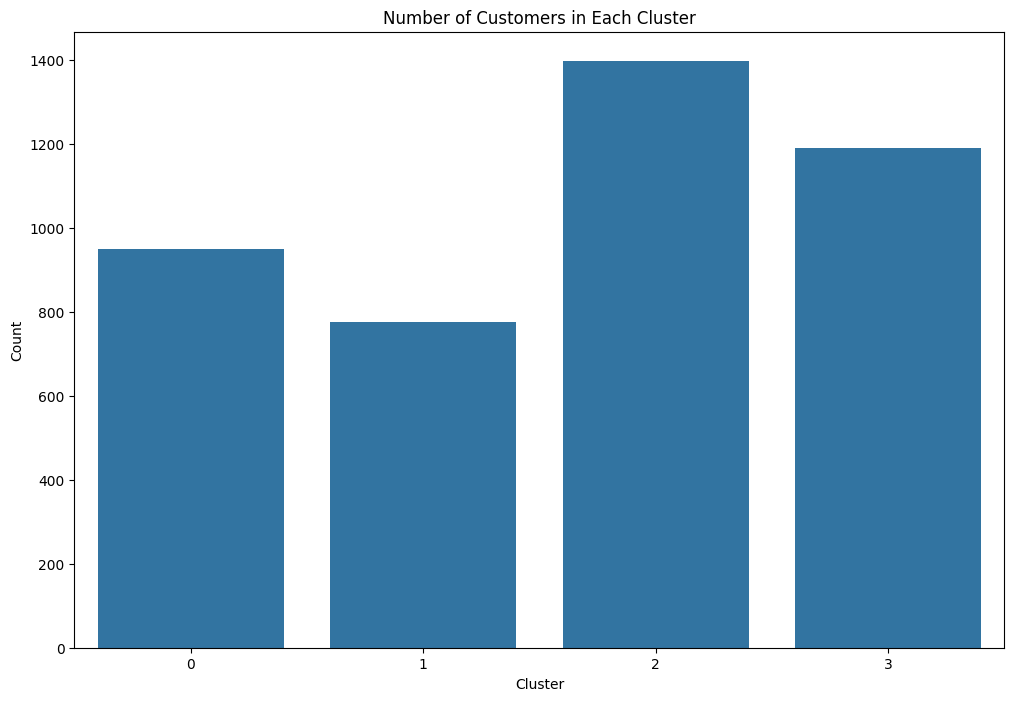

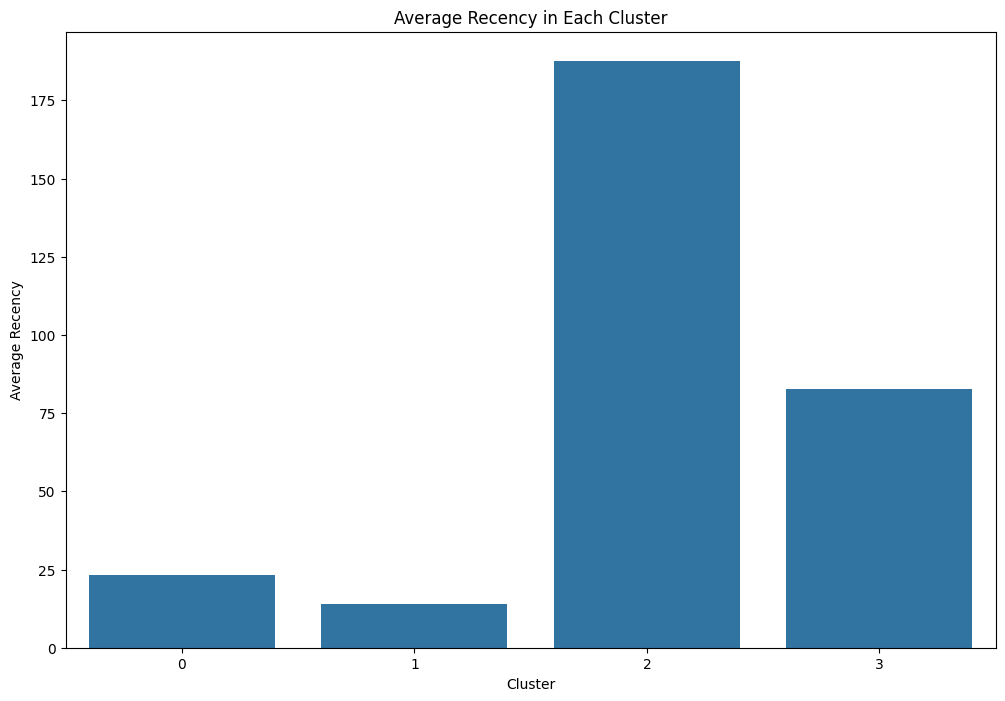

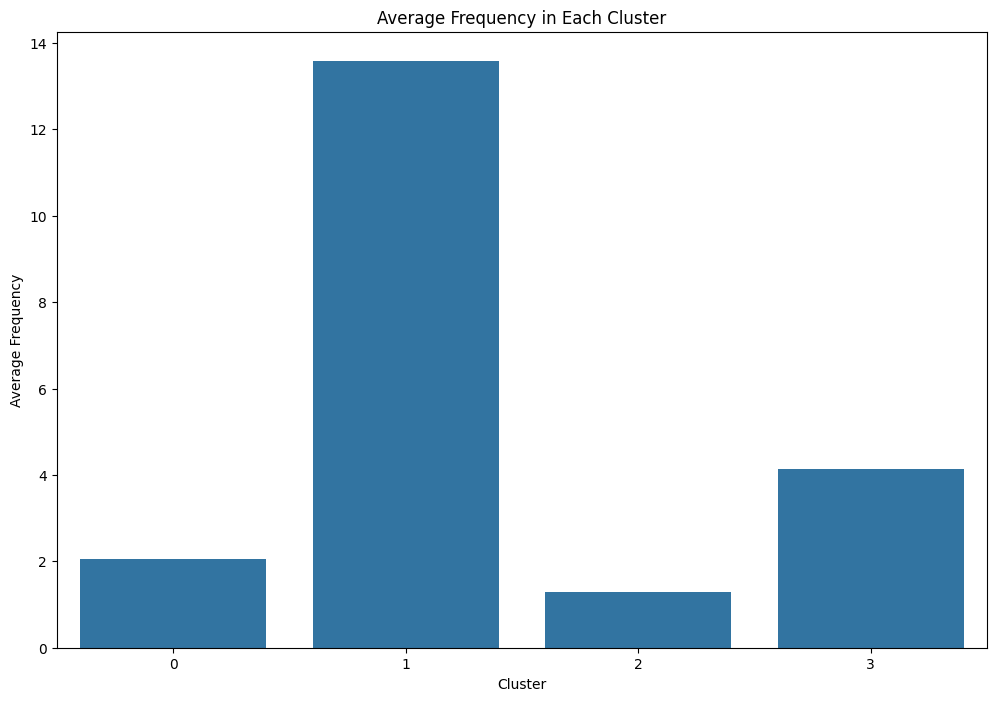

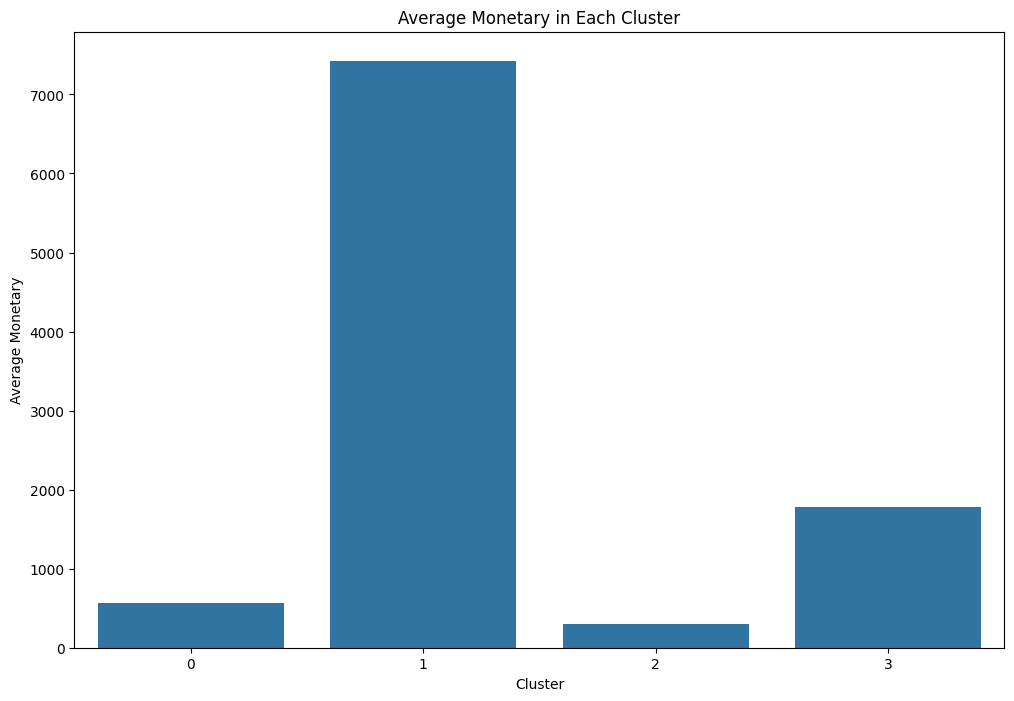

In [27]:
    n_clusters = 4
    # Log transformation and standardization
    rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_log)

    # Elbow method for determining optimal clusters
    sse = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled)
        sse[k] = kmeans.inertia_
    plt.figure(figsize=(10, 6))
    plt.plot(list(sse.keys()), list(sse.values()), marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Determining Optimal Clusters")
    plt.show()

    # Apply K-Means with chosen number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

    # Summarize clusters
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Cluster': 'count'
    }).rename(columns={'Cluster': 'Count'}).reset_index()

    # Visualize cluster summary
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Cluster', y='Count', data=cluster_summary)
    plt.title('Number of Customers in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()

    for metric in ['Recency', 'Frequency', 'Monetary']:
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Cluster', y=metric, data=cluster_summary)
        plt.title(f'Average {metric} in Each Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(f'Average {metric}')
        plt.show()



In [19]:
print(df.columns)
print(rfm.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalSales'],
      dtype='object')
Index(['Recency', 'Frequency', 'Monetary', 'RecencyScore', 'FrequencyScore',
       'MonetaryScore', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score_Str',
       'RFM_Score', 'Segment', 'Cluster'],
      dtype='object')


In [20]:
import plotly.express as px

# Mapping cluster labels for better readability
segment_map = {
    0: "Occasional Buyers",
    1: "At-Risk Customers",
    2: "Loyal Customers",
    3: "High-Value Customers"
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

fig = px.sunburst(rfm, path=['Segment', 'Cluster'], values='Monetary',
                  color='Cluster', hover_data=['Recency', 'Frequency'])

fig.update_layout(title="🌞 Customer Segmentation - Sunburst Chart")
fig.show()


In [21]:
import pandas as pd
import plotly.graph_objects as go

# Group by cluster and calculate mean values
cluster_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Create Radar Chart
fig = go.Figure()
for cluster in cluster_avg.index:
    fig.add_trace(go.Scatterpolar(
        r=cluster_avg.loc[cluster].values,
        theta=['Recency', 'Frequency', 'Monetary'],
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="🕸️ RFM Profile Comparison Across Customer Segments"
)
fig.show()


In [31]:
import plotly.express as px

fig = px.sunburst(rfm, path=['Segment', 'Cluster'], values='Monetary',
                  color='Cluster', hover_data=['Recency', 'Frequency'])

fig.update_layout(title="🌞 Customer Segmentation - Sunburst Chart")
fig.show()


In [33]:
import pandas as pd
import plotly.graph_objects as go

# Grouping by cluster and calculating mean values
cluster_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Create Radar Chart
fig = go.Figure()
for cluster in cluster_avg.index:
    fig.add_trace(go.Scatterpolar(
        r=cluster_avg.loc[cluster].values,
        theta=['Recency', 'Frequency', 'Monetary'],
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="🕸️ RFM Profile Comparison Across Customer Segments"
)
fig.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.violinplot(x="Cluster", y="RFM_Score", data=rfm, palette="coolwarm")
plt.title("🎻 RFM Score Distribution Across Segments")
plt.show()


In [ ]:
import plotly.express as px

fig = px.scatter(rfm, x="Recency", y="Monetary", size="Frequency", color="Cluster",
                 animation_frame="RecencyScore", animation_group="Segment",
                 hover_name="Segment", size_max=50,
                 title="💸 Customer Spending Behavior Over Time")

fig.show()


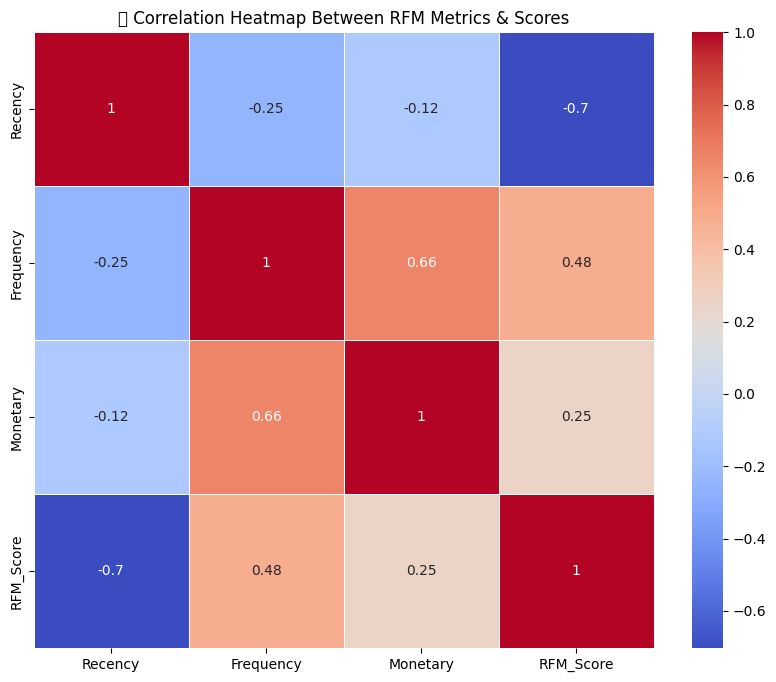

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("🔥 Correlation Heatmap Between RFM Metrics & Scores")
plt.show()


In [34]:
import plotly.express as px

fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                     color='Cluster', opacity=0.8, size_max=10)
fig.update_layout(title="🚀 3D Customer Segmentation Scatter Plot")
fig.show()

fig.write_html("customer_segmentation.html")



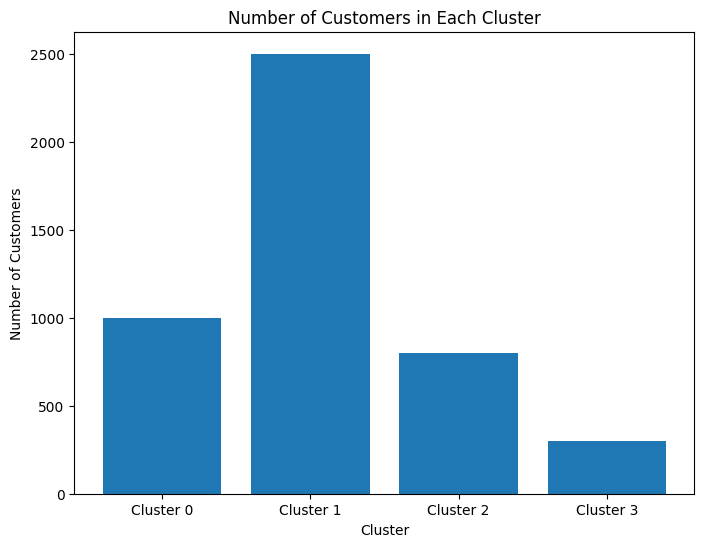

In [24]:
import matplotlib.pyplot as plt

# Example: Save a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], [1000, 2500, 800, 300])
plt.title("Number of Customers in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")

# Save the figure
plt.savefig("customer_clusters.png", dpi=300, bbox_inches="tight")
plt.show()
